Required installations

In [ ]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.4 MB/s eta 0:00:00


### **Section A:**
Analysis of X-ray structures

Structure exists: './pdb_files/pdb193l.ent' 
Structure exists: './pdb_files/pdb194l.ent' 
Structure exists: './pdb_files/pdb1aki.ent' 
Structure exists: './pdb_files/pdb1azf.ent' 
Structure exists: './pdb_files/pdb1bgi.ent' 


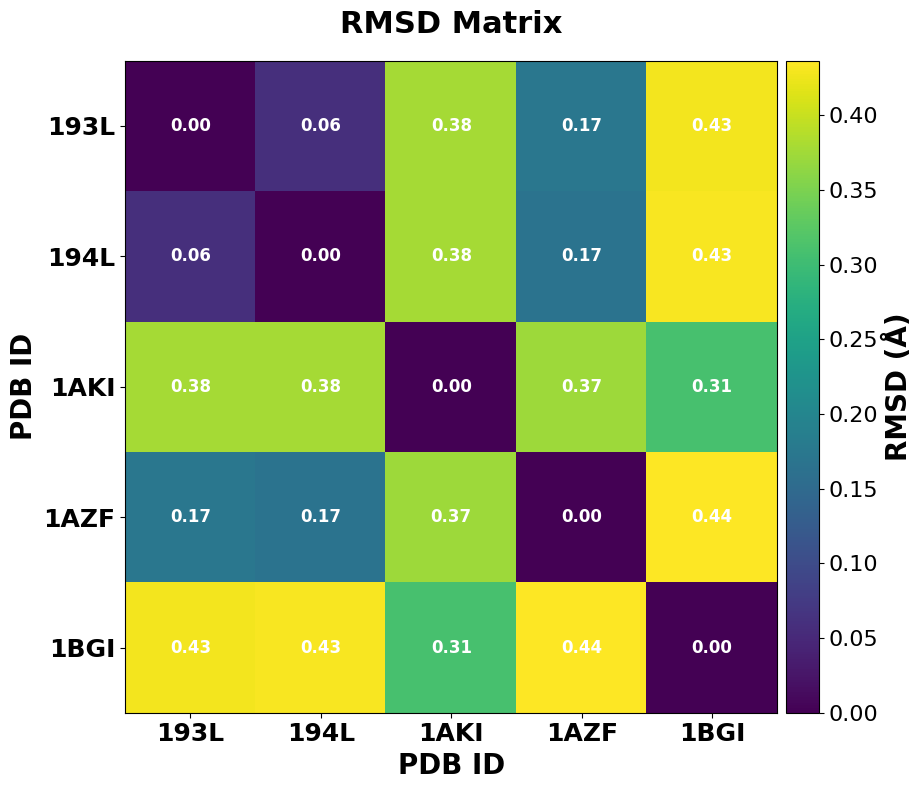

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from Bio.PDB import PDBList, PDBParser, Superimposer, is_aa

# List of PDB IDs
pdb_ids = ["193L", "194L", "1AKI", "1AZF", "1BGI"]

# Fetch PDB files
pdb_dir = "./pdb_files"
pdbl = PDBList()
pdb_files = [pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format="pdb") for pdb_id in pdb_ids]

# Function to extract C-alpha atoms
def get_calpha_atoms(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_file)
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if is_aa(residue, standard=True) and "CA" in residue:
                    ca_atoms.append(residue["CA"])
    return ca_atoms

# Extract C-alpha atoms for all structures
calpha_structures = [get_calpha_atoms(pdb_file) for pdb_file in pdb_files]

# Calculate RMSD matrix
n_structures = len(calpha_structures)
rmsd_matrix = np.zeros((n_structures, n_structures))

for i in range(n_structures):
    for j in range(n_structures):
        # Perform superposition
        sup = Superimposer()
        ref_atoms = calpha_structures[i]
        alt_atoms = calpha_structures[j]
        min_len = min(len(ref_atoms), len(alt_atoms))
        ref_atoms = ref_atoms[:min_len]
        alt_atoms = alt_atoms[:min_len]
        sup.set_atoms(ref_atoms, alt_atoms)
        rmsd_matrix[i, j] = sup.rms
        rmsd_matrix[j, i] = sup.rms

# Plot the RMSD matrix with publication-quality settings
plt.figure(figsize=(10, 8))
cax = plt.imshow(rmsd_matrix, cmap="viridis", interpolation="nearest")

# Add colorbar with enhanced label
cbar = plt.colorbar(cax, pad=0.01)
cbar.ax.set_ylabel("RMSD (Å)", fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=16)  # Adjust tick label size for colorbar

# Adjusting axis labels
plt.xticks(range(len(pdb_ids)), pdb_ids, fontsize=18, fontweight='bold')
plt.yticks(range(len(pdb_ids)), pdb_ids, fontsize=18, fontweight='bold')

# Title and axis labels with larger font
plt.title("RMSD Matrix", fontsize=22, pad=20, fontweight='bold')
plt.xlabel("PDB ID", fontsize=20, fontweight='bold')
plt.ylabel("PDB ID", fontsize=20, fontweight='bold')

# Annotate RMSD values in each cell with improved readability
for i in range(n_structures):
    for j in range(n_structures):
        plt.text(j, i, f"{rmsd_matrix[i, j]:.2f}", ha="center", va="center", color="white", fontsize=12, fontweight='bold')

# Tight layout to avoid clipping
plt.tight_layout()

# Save the plot as a high-quality image
plt.savefig("rmsd_matrix.png", dpi=300, bbox_inches="tight")

plt.show()


### **Section B:**
Analysis of NMR Structures

Note: Currently this notebook supports NMR structural analysis of proteins only.

### **EXERCISE 1: Pairwise RMSD Calculation**

---



Structure exists: './pdb1d3z.ent' 


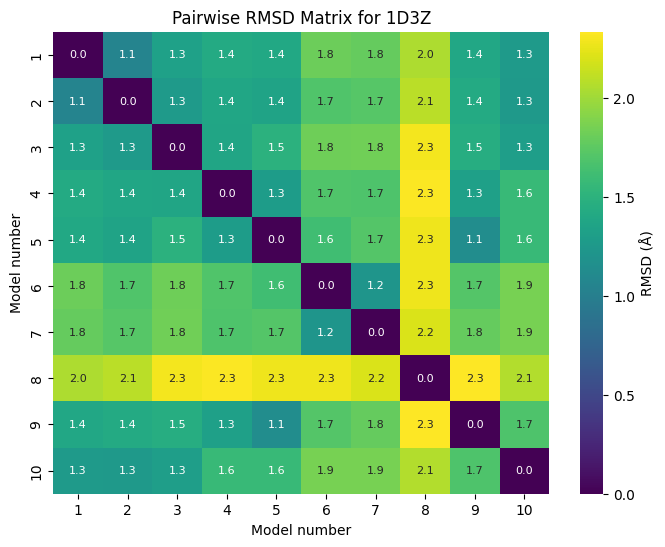

In [ ]:
# Import necessary libraries
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to download PDB file and calculate pairwise RMSD
def download_and_calculate_rmsd(pdb_id):
    pdbl = PDB.PDBList()

    # Download the PDB file
    pdb_file = pdbl.retrieve_pdb_file(pdb_id, pdir='.', file_format='pdb')

    # Load the structure
    pdb_parser = PDB.PDBParser(QUIET=True)
    structure = pdb_parser.get_structure(pdb_id, pdb_file)

    # Calculate pairwise RMSD
    model_list = [model for model in structure]
    num_models = len(model_list)
    rmsd_matrix = np.zeros((num_models, num_models))

    for i in range(num_models):
        for j in range(i + 1, num_models):
            # Align and calculate RMSD
            super_imposer = PDB.Superimposer()
            super_imposer.set_atoms(list(model_list[i].get_atoms()), list(model_list[j].get_atoms()))
            rmsd_matrix[i, j] = super_imposer.rms
            rmsd_matrix[j, i] = super_imposer.rms

    return rmsd_matrix

# Define the PDB ID
pdb_id = '1D3Z'  # Replace with your desired PDB ID

# Calculate RMSD matrix
rmsd_matrix = download_and_calculate_rmsd(pdb_id)

#Plotting the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(rmsd_matrix, cmap='viridis', cbar_kws={'label': 'RMSD (Å)'}, annot=True, fmt=".1f", annot_kws={"size": 8})
num_models = rmsd_matrix.shape[0]
ax.set_xticks(np.arange(num_models) + 0.5)
ax.set_yticks(np.arange(num_models) + 0.5)
ax.set_xticklabels(np.arange(1, num_models + 1))
ax.set_yticklabels(np.arange(1, num_models + 1))
plt.title(f'Pairwise RMSD Matrix for {pdb_id}')
plt.xlabel('Model number')
plt.ylabel('Model number')
plt.show()

### **EXERCISE 2A: Finding Average(Mean) Structure from the ensemble of structures**

In [ ]:
import numpy as np
from Bio.PDB import PDBParser
import requests
from google.colab import files

def download_pdb(pdb_id):
    #Download PDB file from the RCSB PDB database
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    if response.status_code == 200:
        with open(f"{pdb_id}.pdb", "wb") as f:
            f.write(response.content)
        print(f"PDB file {pdb_id}.pdb downloaded successfully!")
    else:
        raise FileNotFoundError(f"PDB file {pdb_id}.pdb not found in the RCSB PDB database.")

def calculate_mean_structure(pdb_id):
    #Calculate the mean structure from an ensemble of PDB models
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, f"{pdb_id}.pdb")

    atom_coords = {}
    atom_details = {}

    # Loop through models to gather coordinates for each atom
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_id = (atom.get_name(), chain.get_id(), residue.get_id(), residue.get_resname())
                    if atom_id not in atom_coords:
                        atom_coords[atom_id] = []
                        atom_details[atom_id] = {
                            'atom_name': atom.get_name(),
                            'residue_name': residue.get_resname(),
                            'chain_id': chain.get_id(),
                            'residue_id': residue.get_id(),
                            'element': atom.element
                        }
                    atom_coords[atom_id].append(atom.get_coord())

    mean_structure = []
    for atom_id, coords in atom_coords.items():
        mean_coord = np.mean(coords, axis=0)
        atom_info = atom_details[atom_id]
        mean_structure.append({
            'atom_name': atom_info['atom_name'],
            'residue_name': atom_info['residue_name'],
            'chain_id': atom_info['chain_id'],
            'residue_id': atom_info['residue_id'],
            'coords': mean_coord,
            'element': atom_info['element']
        })

    return mean_structure

def save_mean_structure(mean_structure, pdb_id):
    #Save mean structure to a PDB file
    file_name = f"{pdb_id}_mean.pdb"
    with open(file_name, "w") as f:
        for i, atom in enumerate(mean_structure, start=1):
            residue_num = atom['residue_id'][1] if isinstance(atom['residue_id'], tuple) else atom['residue_id']
            f.write(f"ATOM  {i:>5} {atom['atom_name']:<4} {atom['residue_name']:<3} {atom['chain_id']:>1}{residue_num:>4}    {atom['coords'][0]:>8.3f}{atom['coords'][1]:>8.3f}{atom['coords'][2]:>8.3f}  1.00  0.00           {atom['element']:>2}\n")

    print(f"Mean structure saved as {file_name}")
    files.download(file_name)

def main(pdb_id):
    download_pdb(pdb_id)
    mean_structure = calculate_mean_structure(pdb_id)
    save_mean_structure(mean_structure, pdb_id)

if __name__ == "__main__":
    pdb_id = "1D3Z"  # Replace with the PDB ID of the NMR structure
    main(pdb_id)

PDB file 1D3Z.pdb downloaded successfully!
Mean structure saved as 1D3Z_mean.pdb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **EXERCISE 2B: Finding Representative structure(Mode structure) from the ensemble of structures**

In [ ]:
import numpy as np
from Bio.PDB import *
from sklearn.cluster import AgglomerativeClustering
import io
from google.colab import files

class NMR:
    def __init__(self, pdb_id):
        self.pdb_id = pdb_id
        self.structure = self.load_structure(pdb_id)
        self.models = self.extract_models()
        self.num_models = len(self.models)
        self.ca_coords = self.get_ca_coords()
        self.mode_structure, self.labels, self.largest_cluster_label, self.mode_structure_index = self.find_mode_structure()

    def fetch_pdb(self, pdb_id):
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        with urllib.request.urlopen(url) as response:
            pdb_data = response.read().decode('utf-8')
        return pdb_data

    def load_structure(self, pdb_id):
        pdb_data = self.fetch_pdb(pdb_id)
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("NMR", io.StringIO(pdb_data))
        return structure

    def extract_models(self):
        models = [model for model in self.structure.get_models()]
        return models

    def get_ca_coords(self):
        ca_coords = []
        for model in self.models:
            model_ca_coords = [atom.get_coord() for atom in model.get_atoms() if atom.get_name() == 'CA']
            ca_coords.append(model_ca_coords)
        return np.array(ca_coords)

    def find_mode_structure(self):
        # Calculate pairwise RMSD
        rmsd_matrix = np.zeros((self.num_models, self.num_models))
        for i in range(self.num_models):
            for j in range(i + 1, self.num_models):
                rmsd = self.calculate_rmsd(self.ca_coords[i], self.ca_coords[j])
                rmsd_matrix[i, j] = rmsd
                rmsd_matrix[j, i] = rmsd

        # Perform hierarchical clustering
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=5.0, affinity='precomputed', linkage='average')
        clustering.fit(rmsd_matrix)
        labels = clustering.labels_
        self.labels = labels

        # Identify the largest cluster
        unique_labels, counts = np.unique(labels, return_counts=True)
        num_clusters = len(unique_labels)
        print(f"Number of clusters formed: {num_clusters}")
        for label in unique_labels:
            models_in_cluster = np.where(labels == label)[0] + 1  # Adjust model numbering
            print(f"Cluster {label}: Models {models_in_cluster}, Count: {counts[label]}")

        largest_cluster_label = unique_labels[np.argmax(counts)]
        print(f"Cluster considered for mode structure: {largest_cluster_label}")

        # Find the mode structure in the largest cluster
        cluster_indices = np.where(labels == largest_cluster_label)[0]
        min_avg_rmsd = float('inf')
        mode_structure_index = cluster_indices[0]
        for i in cluster_indices:
            avg_rmsd = np.mean([self.calculate_rmsd(self.ca_coords[i], self.ca_coords[j]) for j in cluster_indices if i != j])
            if avg_rmsd < min_avg_rmsd:
                min_avg_rmsd = avg_rmsd
                mode_structure_index = i

        mode_structure = self.models[mode_structure_index]
        mode_structure_index_1_based = mode_structure_index + 1

        print(f"Model number considered as mode structure: {mode_structure_index_1_based}")

        return mode_structure, labels, largest_cluster_label, mode_structure_index_1_based

    def calculate_rmsd(self, coords1, coords2):
        diff = coords1 - coords2
        rmsd = np.sqrt(np.mean(np.sum(diff ** 2, axis=1)))
        return rmsd

    def write_pdb(self, structure, filename):
        io = PDBIO()
        io.set_structure(structure)
        io.save(filename)

if __name__ == '__main__':
    pdb_id = "1D3Z"  # Replace with the PDB ID of NMR structure
    nmr = NMR(pdb_id)

    # Save mode structure to PDB file
    output_pdb_file = f"{pdb_id}_mode.pdb"
    nmr.write_pdb(nmr.mode_structure, output_pdb_file)
    files.download(output_pdb_file)
    print(f"Mode structure saved as {output_pdb_file}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of clusters formed: 1
Cluster 0: Models [ 1  2  3  4  5  6  7  8  9 10], Count: 10
Cluster considered for mode structure: 0
Model number considered as mode structure: 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mode structure saved as 1D3Z_mode.pdb


### **EXERCISE 4A: RMSD calculation considering Mean structure as reference structure.**

Note:Mean structure is calculated using all the atoms. But RMSD is calculated using only C alpha atoms

PDB file downloaded successfully!
Mean structure saved as 1D3Z_mean.pdb
RMSD values saved as 1D3Z_rmsd-mean.csv


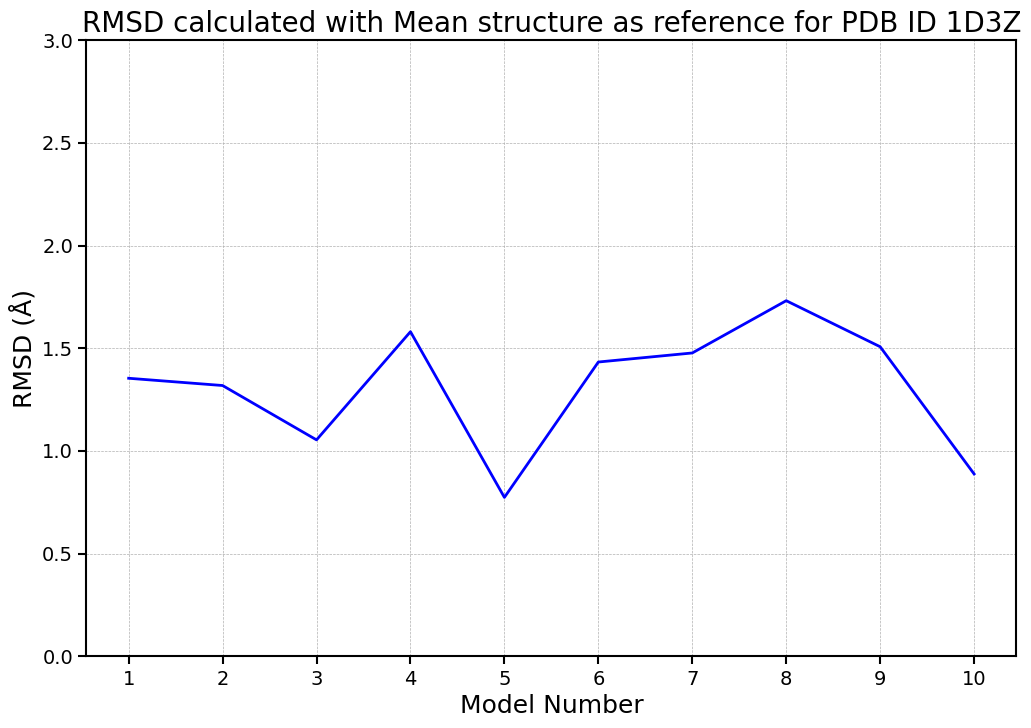

RMSD plot saved as 1D3Z_rmsd_plot-mean.png


In [ ]:
import urllib.request
import numpy as np
import csv
import matplotlib.pyplot as plt

def download_pdb(pdb_id):
    #Download PDB file from RCSB PDB
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    try:
        with urllib.request.urlopen(url) as response:
            pdb_data = response.read().decode('utf-8')
            return pdb_data
    except Exception as e:
        print(f"Error downloading PDB file: {e}")
        return None

def parse_coordinates(pdb_data):
    #Parse atomic coordinates from PDB file
    all_models = []
    ca_models = []
    current_model_all = []
    current_model_ca = []
    atom_info_all = []
    atom_info_ca = []
    ca_indices = []

    for line in pdb_data.split('\n'):
        if line.startswith('MODEL'):
            current_model_all = []
            current_model_ca = []
        elif line.startswith('ENDMDL'):
            all_models.append(current_model_all)
            ca_models.append(current_model_ca)
        elif line.startswith('ATOM'):
            atom_info = line[:30]
            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])
            current_model_all.append([x, y, z])
            atom_info_all.append(atom_info)
            if line[12:16].strip() == 'CA':  # Consider only Cα atoms for ca_models
                current_model_ca.append([x, y, z])
                atom_info_ca.append(atom_info)
                if len(all_models) == 0:  # Capture CA indices only for the first model
                    ca_indices.append(len(current_model_all) - 1)

    return np.array(all_models), np.array(ca_models), atom_info_all, atom_info_ca, ca_indices

def calculate_mean_structure(models):
    #Calculate mean structure from an ensemble of models
    mean_coords = np.mean(models, axis=0)
    return mean_coords

def calculate_rmsd(coords1, coords2):
    #Calculate RMSD between two structures
    diff = coords1 - coords2
    rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
    return rmsd

def save_mean_structure(mean_structure, atom_info_all, pdb_id):
    #Save mean structure to a PDB file
    mean_pdb_file = f"{pdb_id}_mean.pdb"
    with open(mean_pdb_file, "w") as f:
        for i, (info, (x, y, z)) in enumerate(zip(atom_info_all, mean_structure)):
            f.write(f"{info}{x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00\n")
    print(f"Mean structure saved as {mean_pdb_file}")

def save_rmsd_to_csv(rmsd_values, pdb_id):
    """Save RMSD values to a CSV file"""
    rmsd_csv_file = f"{pdb_id}_rmsd-mean.csv"
    with open(rmsd_csv_file, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Model", "RMSD"])
        for model_num, rmsd in enumerate(rmsd_values, start=1):
            writer.writerow([model_num, rmsd])
    print(f"RMSD values saved as {rmsd_csv_file}")

def plot_rmsd(rmsd_values, pdb_id):
    #Plot RMSD values
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, len(rmsd_values) + 1), rmsd_values, linestyle='-', color='b', linewidth=2, markersize=8)
    plt.title(f"RMSD calculated with Mean structure as reference for PDB ID {pdb_id}", fontsize=20)
    plt.xticks(range(1, len(rmsd_values) + 1), fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Model Number", fontsize=18)
    plt.ylabel("RMSD (Å)", fontsize=18)
    plt.ylim(0, 3.0)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().tick_params(width=1.5, length=6)
    plt.savefig(f"{pdb_id}_rmsd_plot-mean.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"RMSD plot saved as {pdb_id}_rmsd_plot-mean.png")

def main(pdb_id):
    # Download PDB file
    pdb_data = download_pdb(pdb_id)
    if pdb_data:
        print("PDB file downloaded successfully!")

        # Parse atomic coordinates
        all_models, ca_models, atom_info_all, atom_info_ca, ca_indices = parse_coordinates(pdb_data)

        if len(all_models) == 0:
            print("No models found in the PDB file.")
            return

        # Calculate mean structure considering all atoms
        mean_structure = calculate_mean_structure(all_models)

        # Save mean structure to PDB file
        save_mean_structure(mean_structure, atom_info_all, pdb_id)

        # Extract mean structure Cα atoms using ca_indices
        mean_structure_ca = mean_structure[ca_indices]

        # Calculate RMSD for each model considering only Cα atoms
        rmsd_values = []
        for model_coords in ca_models:
            rmsd = calculate_rmsd(mean_structure_ca, model_coords)  # Consider only Cα atoms for RMSD
            rmsd_values.append(rmsd)

        # Save RMSD values to CSV file
        save_rmsd_to_csv(rmsd_values, pdb_id)

        # Plot RMSD values
        plot_rmsd(rmsd_values, pdb_id)

if __name__ == "__main__":
    pdb_id = "1D3Z"  # Replace with the PDB ID of NMR structure
    main(pdb_id)


### **Exercise 4B:: RMSD calculation considering Mode structure as reference structure.**

Note:Mode structure is calculated using clustering the models based on pairwise RMSD.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:567: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


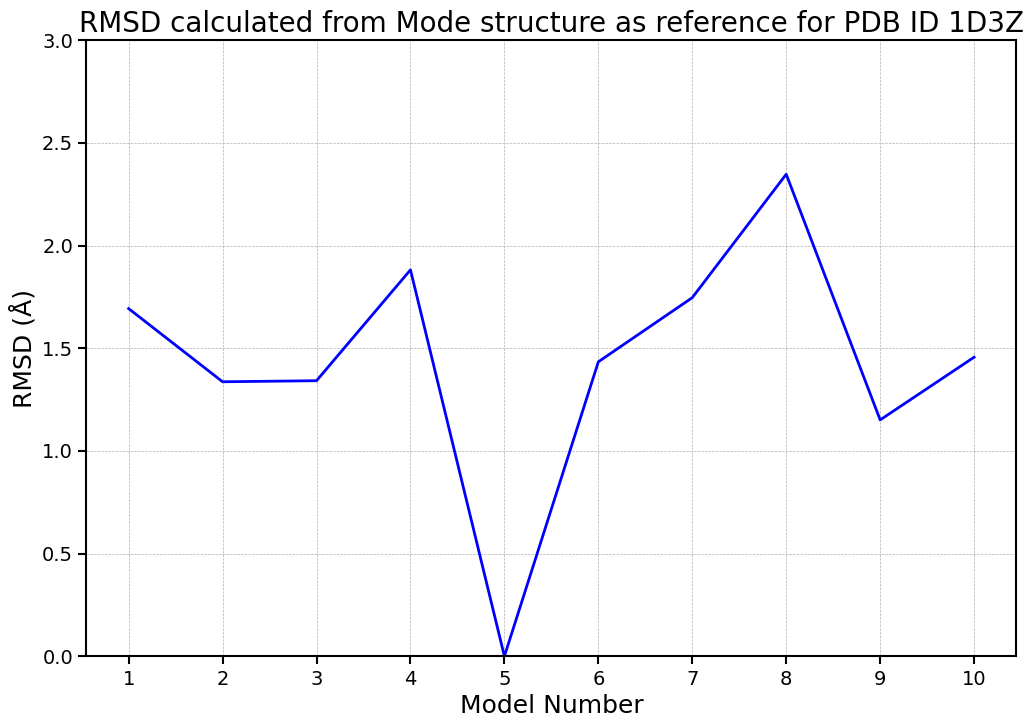

RMSD plot saved as 1D3Z_rmsd_plot-mode.png
Mode structure saved as 1D3Z_mode.pdb


In [ ]:
import numpy as np
import requests
from Bio.PDB import *
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

class NMR:
    def __init__(self, pdb_file):
        self.structure = self.load_structure(pdb_file)
        self.models = self.extract_models()
        self.num_models = len(self.models)
        self.ca_coords = self.get_ca_coords()
        self.mode_structure, self.labels = self.find_mode_structure()
        self.rmsd_to_mode = self.calculate_rmsd_to_mode()

    def load_structure(self, pdb_file):
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("NMR", pdb_file)
        return structure

    def extract_models(self):
        models = [model for model in self.structure.get_models()]
        return models

    def get_ca_coords(self):
        ca_coords = []
        for model in self.models:
            model_ca_coords = [atom.get_coord() for atom in model.get_atoms() if atom.get_name() == 'CA']
            ca_coords.append(model_ca_coords)
        return np.array(ca_coords)

    def find_mode_structure(self):
        # Calculate pairwise RMSD
        rmsd_matrix = np.zeros((self.num_models, self.num_models))
        for i in range(self.num_models):
            for j in range(i + 1, self.num_models):
                rmsd = self.calculate_rmsd(self.ca_coords[i], self.ca_coords[j])
                rmsd_matrix[i, j] = rmsd
                rmsd_matrix[j, i] = rmsd

        # Perform hierarchical clustering
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=5.0, linkage='average').fit(rmsd_matrix)

        # Identify the largest cluster
        labels = clustering.labels_
        unique_labels, counts = np.unique(labels, return_counts=True)
        largest_cluster_label = unique_labels[np.argmax(counts)]

        # Find all models in the largest cluster
        cluster_indices = np.where(labels == largest_cluster_label)[0]

        # Calculate the model with the minimum average RMSD to all other models in the cluster
        min_avg_rmsd = float('inf')
        mode_structure_index = cluster_indices[0]
        for i in cluster_indices:
            avg_rmsd = np.mean([self.calculate_rmsd(self.ca_coords[i], self.ca_coords[j]) for j in cluster_indices if i != j])
            if avg_rmsd < min_avg_rmsd:
                min_avg_rmsd = avg_rmsd
                mode_structure_index = i

        mode_structure = self.models[mode_structure_index]

        return mode_structure, labels

    def calculate_rmsd(self, coords1, coords2):
        # Calculate RMSD between two sets of coordinates
        diff = coords1 - coords2
        rmsd = np.sqrt(np.mean(np.sum(diff ** 2, axis=1)))
        return rmsd

    def calculate_rmsd_to_mode(self):
        # Calculate RMSD for each model's Cα atoms to the mode structure's Cα atoms
        mode_ca_coords = np.array([atom.get_coord() for atom in self.mode_structure.get_atoms() if atom.get_name() == 'CA'])

        rmsd_values = [self.calculate_rmsd(mode_ca_coords, model_ca_coords) for model_ca_coords in self.ca_coords]
        return rmsd_values

    def write_pdb(self, structure, filename):
        # Write structure to PDB file
        io = PDBIO()
        io.set_structure(structure)
        io.save(filename)

def download_pdb(pdb_id, filename):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    response.raise_for_status()
    with open(filename, 'wb') as file:
        file.write(response.content)

def plot_rmsd(rmsd_values, pdb_id):
    #Plot RMSD values
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, len(rmsd_values) + 1), rmsd_values, linestyle='-', color='b', linewidth=2, markersize=8)
    plt.title(f"RMSD calculated from Mode structure as reference for PDB ID {pdb_id}", fontsize=20)
    plt.xticks(range(1, len(rmsd_values) + 1), fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Model Number", fontsize=18)
    plt.ylabel("RMSD (Å)", fontsize=18)
    plt.ylim(0, 3.0)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().tick_params(width=1.5, length=6)
    plt.savefig(f"{pdb_id}_rmsd_plot-mode.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"RMSD plot saved as {pdb_id}_rmsd_plot-mode.png")

if __name__ == '__main__':
    pdb_id = "1D3Z"  # Replace with the PDB ID of NMR structure
    pdb_file = f"{pdb_id}.pdb"

    # Download PDB file
    download_pdb(pdb_id, pdb_file)

    # Initialize NMR class
    nmr = NMR(pdb_file)

    # Calculate RMSD to mode structure (mode Cα atoms only)
    rmsd_to_mode = nmr.calculate_rmsd_to_mode()

    # Plot RMSD values
    plot_rmsd(rmsd_to_mode, pdb_id)

    # Save mode structure to PDB file
    output_pdb_file = f"{pdb_id}_mode.pdb"
    nmr.write_pdb(nmr.mode_structure, output_pdb_file)
    print(f"Mode structure saved as {output_pdb_file}")


### **EXERCISE 5A: RMSF calculation considering Mean structure as reference structure.**

PDB file downloaded successfully!
RMSF values saved as 1D3Z_rmsf.csv


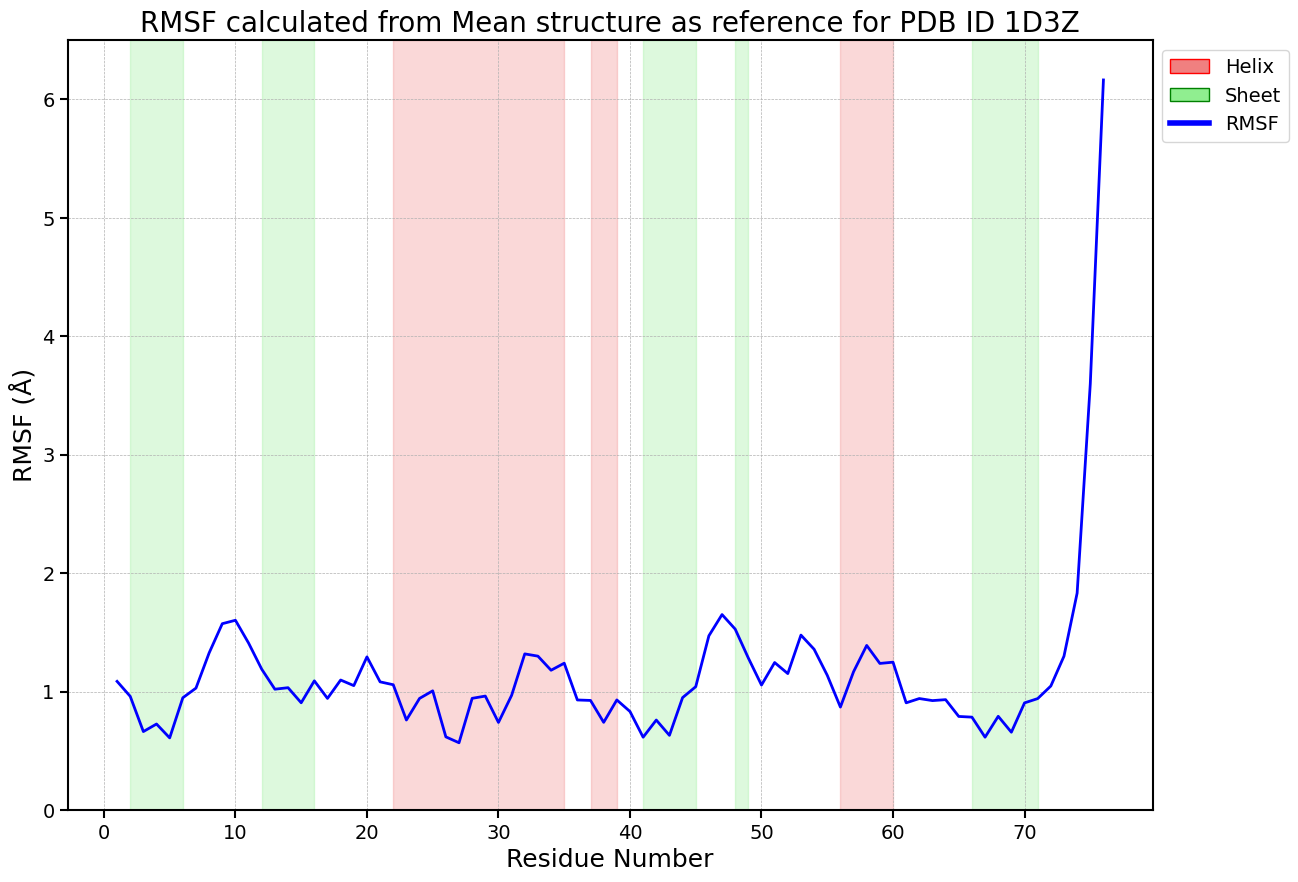

RMSF plot saved as 1D3Z_rmsf_plot-mean.png


In [ ]:
import urllib.request
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def download_pdb(pdb_id):
    #Download PDB file from RCSB PDB
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    try:
        with urllib.request.urlopen(url) as response:
            pdb_data = response.read().decode('utf-8')
            return pdb_data
    except Exception as e:
        print(f"Error downloading PDB file: {e}")
        return None

def parse_coordinates_and_secondary_structure(pdb_data):
    #Parse atomic coordinates and secondary structure from PDB file
    models = []
    residue_numbers = []
    current_model = []
    current_residues = []
    secondary_structure = []

    for line in pdb_data.split('\n'):
        if line.startswith('MODEL'):
            current_model = []
            current_residues = []
        elif line.startswith('ENDMDL'):
            models.append(current_model)
            residue_numbers.append(current_residues)
        elif line.startswith('ATOM') and line[12:16].strip() == 'CA':
            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])
            res_num = int(line[22:26].strip())
            current_model.append([x, y, z])
            current_residues.append(res_num)
        elif line.startswith(('HELIX', 'SHEET')):
            sec_struct_type = line[:6].strip()
            start_res = line[21:26].strip()
            end_res = line[33:37].strip()
            try:
                start_res = int(start_res)
                end_res = int(end_res)
            except ValueError:
                start_res = ''.join(filter(str.isdigit, start_res))
                end_res = ''.join(filter(str.isdigit, end_res))
                if start_res and end_res:
                    start_res = int(start_res)
                    end_res = int(end_res)
            secondary_structure.append((sec_struct_type, start_res, end_res))

    return np.array(models), residue_numbers[0], secondary_structure


def calculate_mean_structure(models):
    #Calculate mean structure from an ensemble of models
    mean_coords = np.mean(models, axis=0)
    return mean_coords

def calculate_rmsf(models, mean_structure):
    #Calculate RMSF for each residue
    diff = models - mean_structure[np.newaxis, :, :]
    rmsf = np.sqrt(np.mean(np.sum(diff**2, axis=2), axis=0))
    return rmsf

def save_rmsf_to_csv(rmsf_values, residue_numbers, pdb_id):
    #Save RMSF values to a CSV file
    rmsf_csv_file = f"{pdb_id}_rmsf.csv"
    with open(rmsf_csv_file, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Residue", "RMSF"])
        for res_num, rmsf in zip(residue_numbers, rmsf_values):
            writer.writerow([res_num, rmsf])
    print(f"RMSF values saved as {rmsf_csv_file}")

def plot_rmsf(rmsf_values, residue_numbers, secondary_structure, pdb_id):
    #Plot RMSF values and secondary structure information
    plt.figure(figsize=(14, 10))
    plt.plot(residue_numbers, rmsf_values, linestyle='-', color='blue', label='RMSF', linewidth=2, markersize=8)

    legend_elements = []
    helix_shown = False
    sheet_shown = False

    for sec_type, start, end in secondary_structure:
        if sec_type == 'HELIX':
            color = 'lightcoral'
            if not helix_shown:
                legend_elements.append(Patch(facecolor=color, edgecolor='red', label='Helix'))
                helix_shown = True
        elif sec_type == 'SHEET':
            color = 'lightgreen'
            if not sheet_shown:
                legend_elements.append(Patch(facecolor=color, edgecolor='green', label='Sheet'))
                sheet_shown = True
        else:
            color = 'grey'

        plt.axvspan(start, end, color=color, alpha=0.3)

    legend_elements.append(Line2D([0], [0], color='blue', lw=4, label='RMSF'))
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)

    plt.title(f"RMSF calculated from Mean structure as reference for PDB ID {pdb_id}", fontsize=20)
    plt.xlabel("Residue Number", fontsize=18)
    plt.ylabel("RMSF (Å)", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 6.5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().tick_params(width=1.5, length=6)
    plt.savefig(f"{pdb_id}_rmsf_plot-mean.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"RMSF plot saved as {pdb_id}_rmsf_plot-mean.png")

def main(pdb_id):
    # Download PDB file
    pdb_data = download_pdb(pdb_id)
    if pdb_data:
        print("PDB file downloaded successfully!")

        # Parse atomic coordinates and secondary structure
        models, residue_numbers, secondary_structure = parse_coordinates_and_secondary_structure(pdb_data)

        if len(models) == 0:
            print("No models found in the PDB file.")
            return

        # Calculate mean structure
        mean_structure = calculate_mean_structure(models)

        # Calculate RMSF for each residue
        rmsf_values = calculate_rmsf(models, mean_structure)

        # Save RMSF values to CSV file
        save_rmsf_to_csv(rmsf_values, residue_numbers, pdb_id)

        # Plot RMSF values with secondary structure information
        plot_rmsf(rmsf_values, residue_numbers, secondary_structure, pdb_id)

if __name__ == "__main__":
    pdb_id = "1D3Z"  # Replace with the PDB ID of NMR structure
    main(pdb_id)


### **EXERCISE 5B: RMSF calculation considering Mode structure as reference structure**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


RMSF values saved to 1D3Z_rmsf.csv


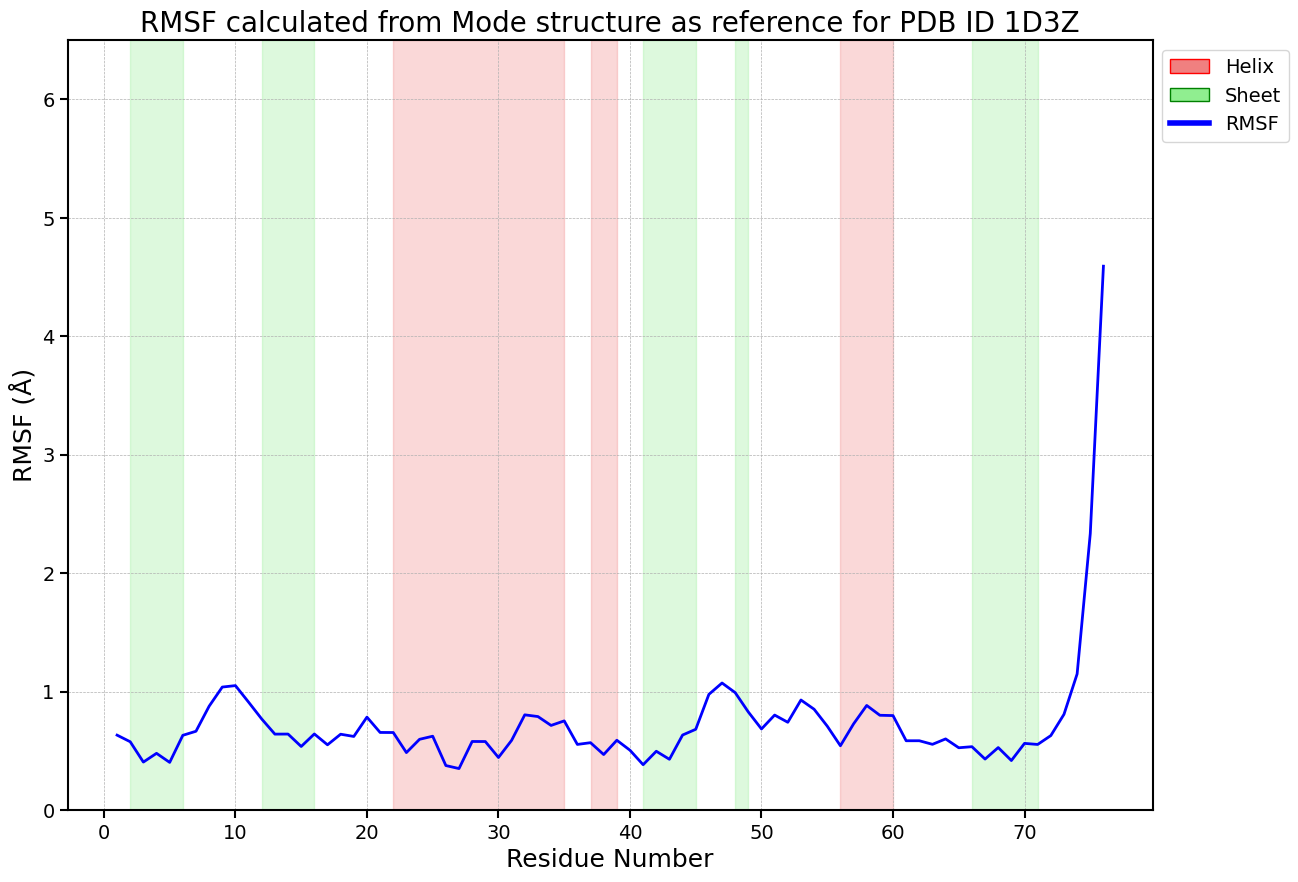

RMSF plot saved as 1D3Z_rmsf_plot-mode.png
Mode structure saved as 1D3Z_mode.pdb


In [ ]:
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from Bio.PDB import *
from sklearn.cluster import AgglomerativeClustering
import csv

class NMR:
    def __init__(self, pdb_file):
        self.structure = self.load_structure(pdb_file)
        self.models = self.extract_models()
        self.num_models = len(self.models)
        self.ca_coords, self.residue_numbers, self.secondary_structure = self.parse_coordinates_and_secondary_structure(pdb_file)
        self.mode_structure, self.labels = self.find_mode_structure()

    def load_structure(self, pdb_file):
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("NMR", pdb_file)
        return structure

    def extract_models(self):
        models = [model for model in self.structure.get_models()]
        return models

    def parse_coordinates_and_secondary_structure(self, pdb_file):
        #Parse atomic coordinates and secondary structure from PDB file
        models = []
        residue_numbers = []
        secondary_structure = []

        current_model = []
        current_residues = []

        with open(pdb_file, 'r') as file:
            for line in file:
                record_type = line[:6].strip()

                if record_type == 'MODEL':
                    current_model = []
                    current_residues = []

                elif record_type == 'ENDMDL':
                    models.append(current_model)
                    residue_numbers.append(current_residues)

                elif record_type == 'ATOM' and line[12:16].strip() == 'CA':
                    x = float(line[30:38])
                    y = float(line[38:46])
                    z = float(line[46:54])
                    res_num = int(line[22:26].strip())
                    current_model.append([x, y, z])
                    current_residues.append(res_num)

                elif record_type in ('HELIX', 'SHEET'):
                    sec_struct_type = line[:6].strip()
                    start_res = line[21:26].strip()
                    end_res = line[33:37].strip()

                    try:
                        start_res = int(start_res)
                        end_res = int(end_res)
                    except ValueError:
                        start_res = ''.join(filter(str.isdigit, start_res))
                        end_res = ''.join(filter(str.isdigit, end_res))
                        if start_res and end_res:
                            start_res = int(start_res)
                            end_res = int(end_res)

                    secondary_structure.append((sec_struct_type, start_res, end_res))

        return np.array(models), residue_numbers[0], secondary_structure

    def find_mode_structure(self):
        # Calculate pairwise RMSD
        rmsd_matrix = np.zeros((self.num_models, self.num_models))
        for i in range(self.num_models):
            for j in range(i + 1, self.num_models):
                rmsd = self.calculate_rmsd(self.ca_coords[i], self.ca_coords[j])
                rmsd_matrix[i, j] = rmsd
                rmsd_matrix[j, i] = rmsd

        # Perform hierarchical clustering
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=5.0, linkage='average').fit(rmsd_matrix)

        # Identify the largest cluster
        labels = clustering.labels_
        unique_labels, counts = np.unique(labels, return_counts=True)
        largest_cluster_label = unique_labels[np.argmax(counts)]

        # Find all models in the largest cluster
        cluster_indices = np.where(labels == largest_cluster_label)[0]

        # Calculate the model with the minimum average RMSD to all other models in the cluster
        min_avg_rmsd = float('inf')
        mode_structure_index = cluster_indices[0]
        for i in cluster_indices:
            avg_rmsd = np.mean([self.calculate_rmsd(self.ca_coords[i], self.ca_coords[j]) for j in cluster_indices if i != j])
            if avg_rmsd < min_avg_rmsd:
                min_avg_rmsd = avg_rmsd
                mode_structure_index = i

        mode_structure = self.models[mode_structure_index]

        return mode_structure, labels

    def calculate_rmsd(self, coords1, coords2):
        # Calculate RMSD between two sets of coordinates
        diff = coords1 - coords2
        rmsd = np.sqrt(np.mean(np.sum(diff ** 2, axis=1)))
        return rmsd

    def calculate_rmsf(self):
        #Calculate RMSF for each residue
        mode_ca_coords = np.array([atom.get_coord() for atom in self.mode_structure.get_atoms() if atom.get_name() == 'CA'])
        rmsf_values = np.sqrt(np.mean((self.ca_coords - mode_ca_coords) ** 2, axis=(0, 2)))
        residue_numbers = np.array(self.residue_numbers)
        return rmsf_values, residue_numbers, self.secondary_structure

    def save_rmsf_to_csv(self, rmsf_values, residue_numbers, pdb_id):
        #Save RMSF values to CSV file
        filename = f"{pdb_id}_rmsf.csv"
        with open(filename, 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(['Residue Number', 'RMSF'])
            for res_num, rmsf in zip(residue_numbers, rmsf_values):
                csvwriter.writerow([res_num, rmsf])
        print(f"RMSF values saved to {filename}")

    def write_pdb(self, structure, filename):
        # Write structure to PDB file
        io = PDBIO()
        io.set_structure(structure)
        io.save(filename)

    def plot_rmsf(self, rmsf_values, residue_numbers, secondary_structure, pdb_id):
        #Plot RMSF values and secondary structure information
        plt.figure(figsize=(14, 10))
        plt.plot(residue_numbers, rmsf_values, linestyle='-', color='blue', label='RMSF', linewidth=2, markersize=8)

        legend_elements = []
        helix_shown = False
        sheet_shown = False

        for sec_type, start, end in secondary_structure:
            if sec_type == 'HELIX':
                color = 'lightcoral'
                if not helix_shown:
                    legend_elements.append(Patch(facecolor=color, edgecolor='red', label='Helix'))
                    helix_shown = True
            elif sec_type == 'SHEET':
                color = 'lightgreen'
                if not sheet_shown:
                    legend_elements.append(Patch(facecolor=color, edgecolor='green', label='Sheet'))
                    sheet_shown = True
            else:
                color = 'grey'

            plt.axvspan(start, end, color=color, alpha=0.3)

        legend_elements.append(plt.Line2D([0], [0], color='blue', lw=4, label='RMSF'))
        plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)

        plt.title(f"RMSF calculated from Mode structure as reference for PDB ID {pdb_id}", fontsize=20)
        plt.xlabel("Residue Number", fontsize=18)
        plt.ylabel("RMSF (Å)", fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylim(0, 6.5)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.gca().spines['top'].set_linewidth(1.5)
        plt.gca().spines['right'].set_linewidth(1.5)
        plt.gca().spines['bottom'].set_linewidth(1.5)
        plt.gca().spines['left'].set_linewidth(1.5)
        plt.gca().tick_params(width=1.5, length=6)
        plt.savefig(f"{pdb_id}_rmsf_plot-mode.png", dpi=300, bbox_inches='tight')
        plt.show()
        print(f"RMSF plot saved as {pdb_id}_rmsf_plot-mode.png")

def download_pdb(pdb_id, filename):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    response.raise_for_status()
    with open(filename, 'wb') as file:
        file.write(response.content)

if __name__ == '__main__':
    pdb_id = "1D3Z"  # Replace with the PDB ID of NMR structure
    pdb_file = f"{pdb_id}.pdb"

    # Download PDB file
    download_pdb(pdb_id, pdb_file)

    # Initialize NMR class
    nmr = NMR(pdb_file)

    # Calculate RMSF
    rmsf_values, residue_numbers, secondary_structure = nmr.calculate_rmsf()

    # Save RMSF to CSV
    nmr.save_rmsf_to_csv(rmsf_values, residue_numbers, pdb_id)

    # Plot RMSF
    nmr.plot_rmsf(rmsf_values, residue_numbers, secondary_structure, pdb_id)

    # Save mode structure to PDB file
    output_pdb_file = f"{pdb_id}_mode.pdb"
    nmr.write_pdb(nmr.mode_structure, output_pdb_file)
    print(f"Mode structure saved as {output_pdb_file}")


### **Additional: Comparision plot of RMSD for invitro vs incells NMR studies**

Note: Give pdb id of invitro studies as pdb_id1 and of in cell studies as pdb_id2

Using Mean structure

PDB file 2ROE downloaded successfully!
Mean structure saved as 2ROE_mean.pdb
RMSD values saved as 2ROE_rmsd-mean.csv
PDB file 2ROG downloaded successfully!
Mean structure saved as 2ROG_mean.pdb
RMSD values saved as 2ROG_rmsd-mean.csv


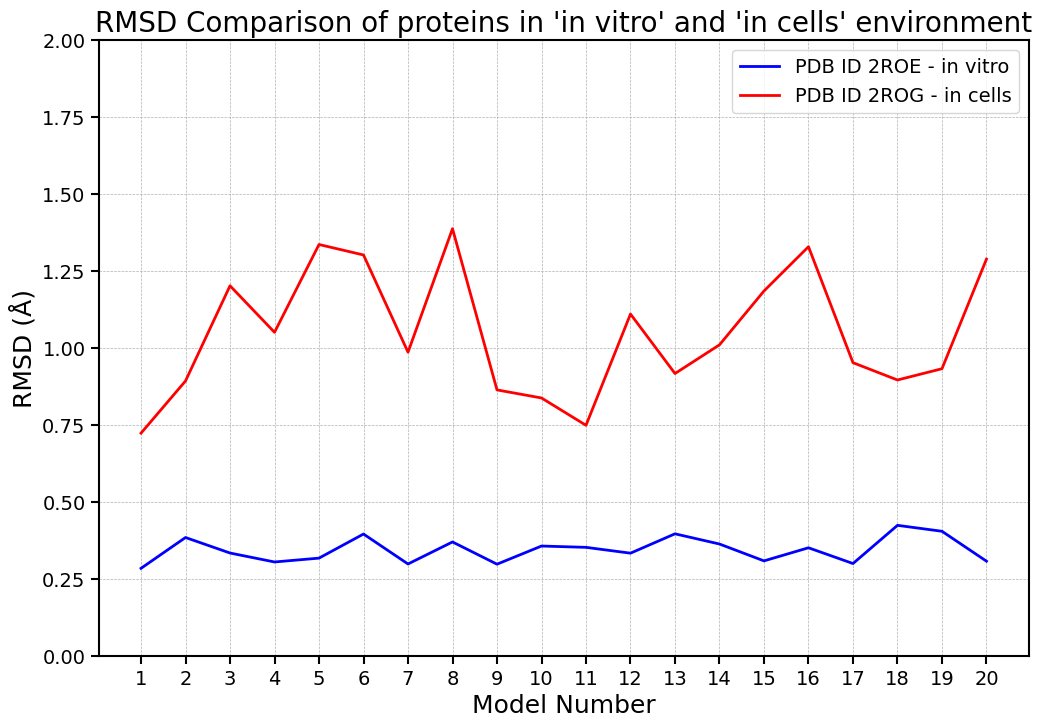

RMSD comparison plot saved as 2ROE_vs_2ROG_rmsd_comparison.png


In [ ]:
import urllib.request
import numpy as np
import csv
import matplotlib.pyplot as plt

def download_pdb(pdb_id):
    #Download PDB file from RCSB PDB
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    try:
        with urllib.request.urlopen(url) as response:
            pdb_data = response.read().decode('utf-8')
            return pdb_data
    except Exception as e:
        print(f"Error downloading PDB file: {e}")
        return None

def parse_coordinates(pdb_data):
    #Parse atomic coordinates from PDB file
    all_models = []
    ca_models = []
    current_model_all = []
    current_model_ca = []
    atom_info_all = []
    atom_info_ca = []
    ca_indices = []

    for line in pdb_data.split('\n'):
        if line.startswith('MODEL'):
            current_model_all = []
            current_model_ca = []
        elif line.startswith('ENDMDL'):
            all_models.append(current_model_all)
            ca_models.append(current_model_ca)
        elif line.startswith('ATOM'):
            atom_info = line[:30]
            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])
            current_model_all.append([x, y, z])
            atom_info_all.append(atom_info)
            if line[12:16].strip() == 'CA':  # Consider only Cα atoms for ca_models
                current_model_ca.append([x, y, z])
                atom_info_ca.append(atom_info)
                if len(all_models) == 0:  # Capture CA indices only for the first model
                    ca_indices.append(len(current_model_all) - 1)

    return np.array(all_models), np.array(ca_models), atom_info_all, atom_info_ca, ca_indices

def calculate_mean_structure(models):
    #Calculate mean structure from an ensemble of models
    mean_coords = np.mean(models, axis=0)
    return mean_coords

def calculate_rmsd(coords1, coords2):
    #Calculate RMSD between two structures
    diff = coords1 - coords2
    rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
    return rmsd

def save_mean_structure(mean_structure, atom_info_all, pdb_id):
    #Save mean structure to a PDB file
    mean_pdb_file = f"{pdb_id}_mean.pdb"
    with open(mean_pdb_file, "w") as f:
        for i, (info, (x, y, z)) in enumerate(zip(atom_info_all, mean_structure)):
            f.write(f"{info}{x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00\n")
    print(f"Mean structure saved as {mean_pdb_file}")

def save_rmsd_to_csv(rmsd_values, pdb_id):
    #Save RMSD values to a CSV file
    rmsd_csv_file = f"{pdb_id}_rmsd-mean.csv"
    with open(rmsd_csv_file, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Model", "RMSD"])
        for model_num, rmsd in enumerate(rmsd_values, start=1):
            writer.writerow([model_num, rmsd])
    print(f"RMSD values saved as {rmsd_csv_file}")

def plot_rmsd_comparison(rmsd_values1, pdb_id1, rmsd_values2, pdb_id2):
    #Plot RMSD values for comparison
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, len(rmsd_values1) + 1), rmsd_values1, linestyle='-', color='b', linewidth=2, markersize=8, label=f'PDB ID {pdb_id1} - in vitro')
    plt.plot(range(1, len(rmsd_values2) + 1), rmsd_values2, linestyle='-', color='r', linewidth=2, markersize=8, label=f'PDB ID {pdb_id2} - in cells')
    plt.title(f"RMSD Comparison of proteins in 'in vitro' and 'in cells' environment", fontsize=20)
    plt.xticks(range(1, max(len(rmsd_values1), len(rmsd_values2)) + 1), fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Model Number", fontsize=18)
    plt.ylabel("RMSD (Å)", fontsize=18)
    plt.ylim(0, 2.0)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().tick_params(width=1.5, length=6)
    plt.legend(fontsize=14)
    plt.savefig(f"{pdb_id1}_vs_{pdb_id2}_rmsd_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"RMSD comparison plot saved as {pdb_id1}_vs_{pdb_id2}_rmsd_comparison.png")

def process_pdb(pdb_id):
    # Download PDB file
    pdb_data = download_pdb(pdb_id)
    if pdb_data:
        print(f"PDB file {pdb_id} downloaded successfully!")

        # Parse atomic coordinates
        all_models, ca_models, atom_info_all, atom_info_ca, ca_indices = parse_coordinates(pdb_data)

        if len(all_models) == 0:
            print(f"No models found in the PDB file {pdb_id}.")
            return

        # Calculate mean structure considering all atoms
        mean_structure = calculate_mean_structure(all_models)

        # Save mean structure to PDB file
        save_mean_structure(mean_structure, atom_info_all, pdb_id)

        # Extract mean structure Cα atoms using ca_indices
        mean_structure_ca = mean_structure[ca_indices]

        # Calculate RMSD for each model considering only Cα atoms
        rmsd_values = []
        for model_coords in ca_models:
            rmsd = calculate_rmsd(mean_structure_ca, model_coords)  # Consider only Cα atoms for RMSD
            rmsd_values.append(rmsd)

        # Save RMSD values to CSV file
        save_rmsd_to_csv(rmsd_values, pdb_id)

        return rmsd_values
    return []

def main(pdb_id1, pdb_id2):
    rmsd_values1 = process_pdb(pdb_id1)
    rmsd_values2 = process_pdb(pdb_id2)

    if rmsd_values1 and rmsd_values2:
        # Plot RMSD comparison
        plot_rmsd_comparison(rmsd_values1, pdb_id1, rmsd_values2, pdb_id2)

if __name__ == "__main__":
    pdb_id1 = "2ROE"  # Replace with the first PDB ID you want to analyze
    pdb_id2 = "2ROG"  # Replace with the second PDB ID you want to analyze
    main(pdb_id1, pdb_id2)


Using Mode structure

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


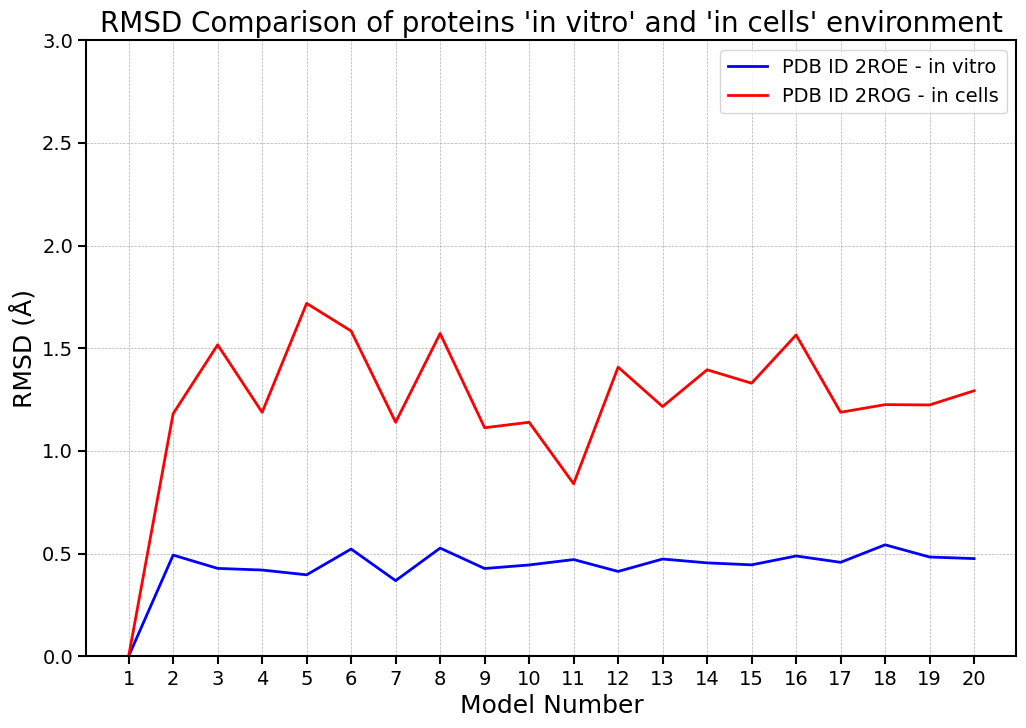

RMSD comparison plot saved as 2ROE_vs_2ROG_rmsd_comparison.png
Mode structure for 2ROE saved as 2ROE_mode.pdb
Mode structure for 2ROG saved as 2ROG_mode.pdb


In [ ]:
import numpy as np
import requests
from Bio.PDB import *
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

class NMR:
    def __init__(self, pdb_file):
        self.structure = self.load_structure(pdb_file)
        self.models = self.extract_models()
        self.num_models = len(self.models)
        self.ca_coords = self.get_ca_coords()
        self.mode_structure, self.labels = self.find_mode_structure()
        self.rmsd_to_mode = self.calculate_rmsd_to_mode()

    def load_structure(self, pdb_file):
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("NMR", pdb_file)
        return structure

    def extract_models(self):
        models = [model for model in self.structure.get_models()]
        return models

    def get_ca_coords(self):
        ca_coords = []
        for model in self.models:
            model_ca_coords = [atom.get_coord() for atom in model.get_atoms() if atom.get_name() == 'CA']
            ca_coords.append(model_ca_coords)
        return np.array(ca_coords)

    def find_mode_structure(self):
        # Calculate pairwise RMSD
        rmsd_matrix = np.zeros((self.num_models, self.num_models))
        for i in range(self.num_models):
            for j in range(i + 1, self.num_models):
                rmsd = self.calculate_rmsd(self.ca_coords[i], self.ca_coords[j])
                rmsd_matrix[i, j] = rmsd
                rmsd_matrix[j, i] = rmsd

        # Perform hierarchical clustering
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=5.0, linkage='average').fit(rmsd_matrix)

        # Identify the largest cluster
        labels = clustering.labels_
        unique_labels, counts = np.unique(labels, return_counts=True)
        largest_cluster_label = unique_labels[np.argmax(counts)]

        # Find all models in the largest cluster
        cluster_indices = np.where(labels == largest_cluster_label)[0]

        # Calculate the model with the minimum average RMSD to all other models in the cluster
        min_avg_rmsd = float('inf')
        mode_structure_index = cluster_indices[0]
        for i in cluster_indices:
            avg_rmsd = np.mean([self.calculate_rmsd(self.ca_coords[i], self.ca_coords[j]) for j in cluster_indices if i != j])
            if avg_rmsd < min_avg_rmsd:
                min_avg_rmsd = avg_rmsd
                mode_structure_index = i

        mode_structure = self.models[mode_structure_index]

        return mode_structure, labels

    def calculate_rmsd(self, coords1, coords2):
        # Calculate RMSD between two sets of coordinates
        diff = coords1 - coords2
        rmsd = np.sqrt(np.mean(np.sum(diff ** 2, axis=1)))
        return rmsd

    def calculate_rmsd_to_mode(self):
        # Calculate RMSD for each model's Cα atoms to the mode structure's Cα atoms
        mode_ca_coords = np.array([atom.get_coord() for atom in self.mode_structure.get_atoms() if atom.get_name() == 'CA'])

        rmsd_values = [self.calculate_rmsd(mode_ca_coords, model_ca_coords) for model_ca_coords in self.ca_coords]
        return rmsd_values

    def write_pdb(self, structure, filename):
        # Write structure to PDB file
        io = PDBIO()
        io.set_structure(structure)
        io.save(filename)

def download_pdb(pdb_id, filename):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    response.raise_for_status()  # Ensure we got a valid response
    with open(filename, 'wb') as file:
        file.write(response.content)

def plot_rmsd(rmsd_values, pdb_id, color, label):
    #Plot RMSD values
    plt.plot(range(1, len(rmsd_values) + 1), rmsd_values, linestyle='-', color=color, linewidth=2, markersize=8, label=label)

def plot_rmsd_comparison(rmsd_values1, pdb_id1, rmsd_values2, pdb_id2):
    #Plot RMSD values for comparison
    plt.figure(figsize=(12, 8))
    plot_rmsd(rmsd_values1, pdb_id1, 'b', f'PDB ID {pdb_id1} - in vitro')
    plot_rmsd(rmsd_values2, pdb_id2, 'r', f'PDB ID {pdb_id2} - in cells')
    plt.title(f"RMSD Comparison of proteins 'in vitro' and 'in cells' environment", fontsize=20)
    plt.xticks(range(1, max(len(rmsd_values1), len(rmsd_values2)) + 1), fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Model Number", fontsize=18)
    plt.ylabel("RMSD (Å)", fontsize=18)
    plt.ylim(0, 3.0)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().tick_params(width=1.5, length=6)
    plt.legend(fontsize=14)
    plt.savefig(f"{pdb_id1}_vs_{pdb_id2}_rmsd_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"RMSD comparison plot saved as {pdb_id1}_vs_{pdb_id2}_rmsd_comparison.png")

if __name__ == '__main__':
    pdb_id1 = "2ROE"  # Replace with your first PDB ID
    pdb_file1 = f"{pdb_id1}.pdb"
    pdb_id2 = "2ROG"  # Replace with your second PDB ID
    pdb_file2 = f"{pdb_id2}.pdb"

    # Download PDB files
    download_pdb(pdb_id1, pdb_file1)
    download_pdb(pdb_id2, pdb_file2)

    # Initialize NMR classes
    nmr1 = NMR(pdb_file1)
    nmr2 = NMR(pdb_file2)

    # Calculate RMSD to mode structure (mode Cα atoms only)
    rmsd_to_mode1 = nmr1.calculate_rmsd_to_mode()
    rmsd_to_mode2 = nmr2.calculate_rmsd_to_mode()

    # Plot RMSD comparison
    plot_rmsd_comparison(rmsd_to_mode1, pdb_id1, rmsd_to_mode2, pdb_id2)

    # Save mode structures to PDB files
    output_pdb_file1 = f"{pdb_id1}_mode.pdb"
    nmr1.write_pdb(nmr1.mode_structure, output_pdb_file1)
    print(f"Mode structure for {pdb_id1} saved as {output_pdb_file1}")

    output_pdb_file2 = f"{pdb_id2}_mode.pdb"
    nmr2.write_pdb(nmr2.mode_structure, output_pdb_file2)
    print(f"Mode structure for {pdb_id2} saved as {output_pdb_file2}")


Better to have separate RMSF plots for invitro vs incells NMR studies so that differences in the secondary structure can be investiagted easily. Use codes provided earlier.

### **Additional: Comparision plot of RMSf for invitro vs incells NMR studies**

Note: Give pdb id of invitro studies as pdb_id1 and of in cell studies as pdb_id2

Using Mean structure as reference

Processing PDB ID: 2ROE (in-vitro condition)
PDB file downloaded successfully!
RMSF values saved as 2ROE_rmsf.csv


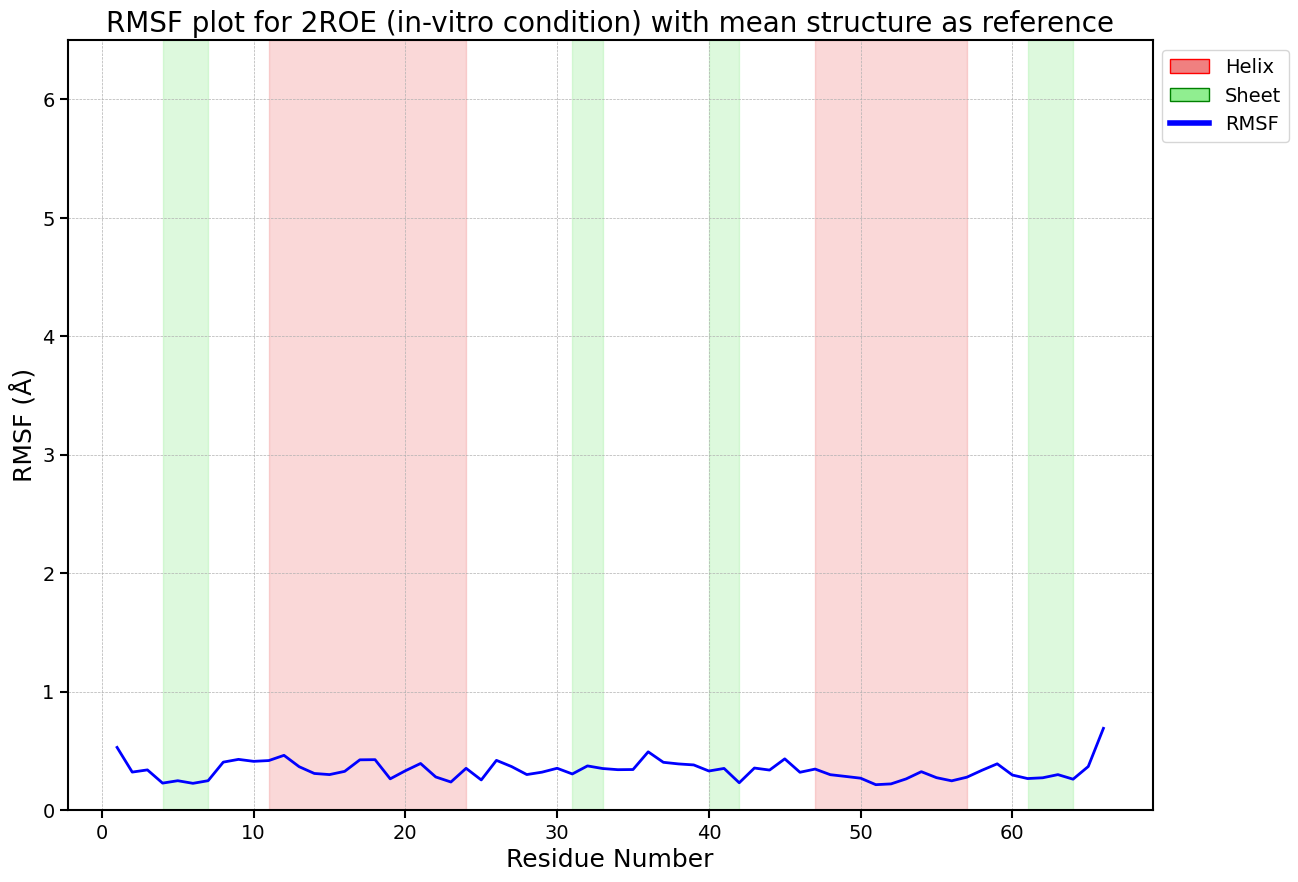

RMSF plot saved as 2ROE_rmsf_plot-in-vitro condition.png
Processing PDB ID: 2ROG (in-cell condition)
PDB file downloaded successfully!
RMSF values saved as 2ROG_rmsf.csv


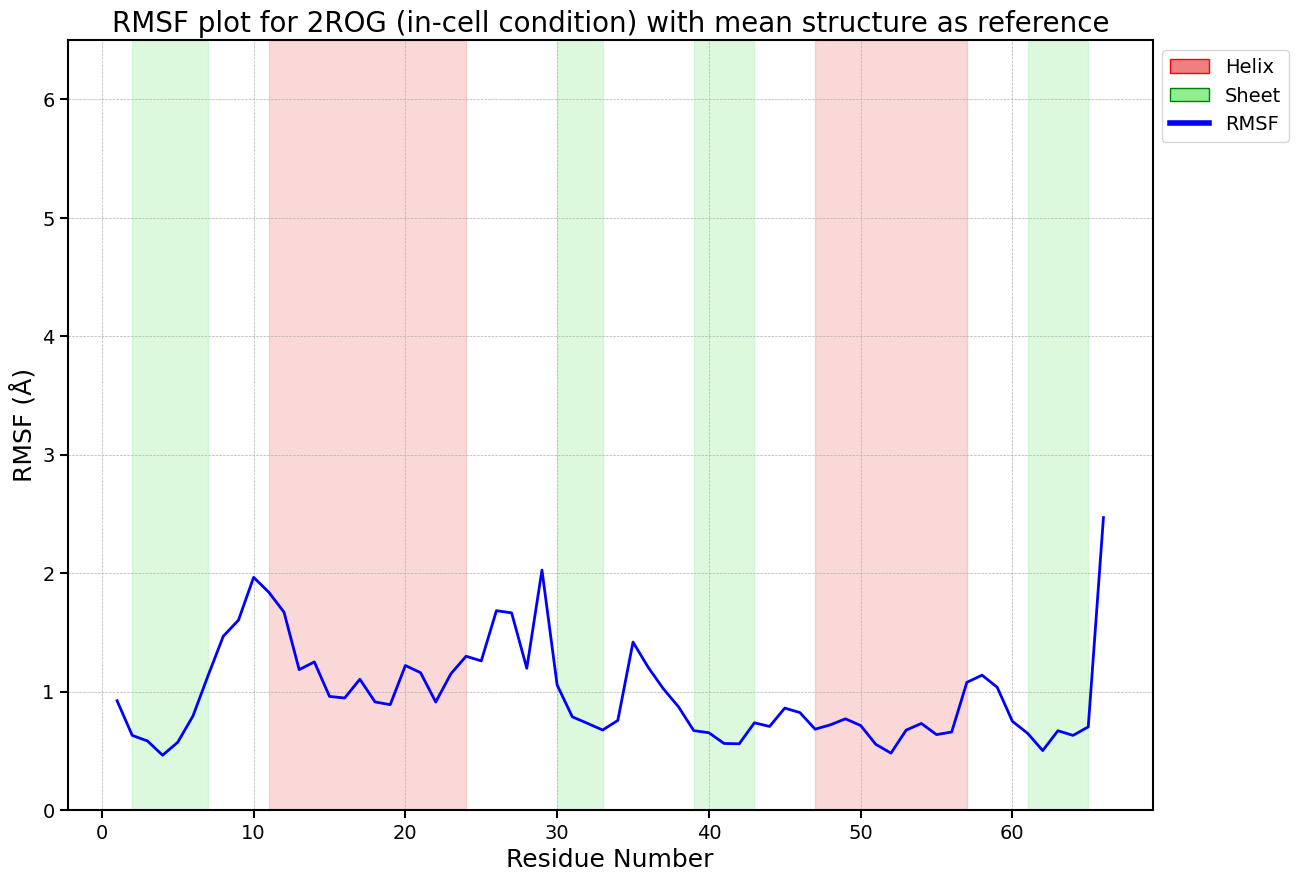

RMSF plot saved as 2ROG_rmsf_plot-in-cell condition.png


In [ ]:
import urllib.request
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def download_pdb(pdb_id):
    #Download PDB file from RCSB PDB
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    try:
        with urllib.request.urlopen(url) as response:
            pdb_data = response.read().decode('utf-8')
            return pdb_data
    except Exception as e:
        print(f"Error downloading PDB file: {e}")
        return None

def parse_coordinates_and_secondary_structure(pdb_data):
    #Parse atomic coordinates and secondary structure from PDB file
    models = []
    residue_numbers = []
    current_model = []
    current_residues = []
    secondary_structure = []

    for line in pdb_data.split('\n'):
        if line.startswith('MODEL'):
            current_model = []
            current_residues = []
        elif line.startswith('ENDMDL'):
            models.append(current_model)
            residue_numbers.append(current_residues)
        elif line.startswith('ATOM') and line[12:16].strip() == 'CA':
            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])
            res_num = int(line[22:26].strip())
            current_model.append([x, y, z])
            current_residues.append(res_num)
        elif line.startswith(('HELIX', 'SHEET')):
            sec_struct_type = line[:6].strip()
            start_res = line[21:26].strip()
            end_res = line[33:37].strip()
            try:
                start_res = int(start_res)
                end_res = int(end_res)
            except ValueError:
                start_res = ''.join(filter(str.isdigit, start_res))
                end_res = ''.join(filter(str.isdigit, end_res))
                if start_res and end_res:
                    start_res = int(start_res)
                    end_res = int(end_res)
            secondary_structure.append((sec_struct_type, start_res, end_res))

    return np.array(models), residue_numbers[0], secondary_structure

def calculate_mean_structure(models):
    #Calculate mean structure from an ensemble of models
    mean_coords = np.mean(models, axis=0)
    return mean_coords

def calculate_rmsf(models, mean_structure):
    #Calculate RMSF for each residue
    diff = models - mean_structure[np.newaxis, :, :]
    rmsf = np.sqrt(np.mean(np.sum(diff**2, axis=2), axis=0))
    return rmsf

def save_rmsf_to_csv(rmsf_values, residue_numbers, pdb_id):
    #Save RMSF values to a CSV file
    rmsf_csv_file = f"{pdb_id}_rmsf.csv"
    with open(rmsf_csv_file, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Residue", "RMSF"])
        for res_num, rmsf in zip(residue_numbers, rmsf_values):
            writer.writerow([res_num, rmsf])
    print(f"RMSF values saved as {rmsf_csv_file}")

def plot_rmsf(rmsf_values, residue_numbers, secondary_structure, pdb_id, condition):
    #Plot RMSF values and secondary structure information
    plt.figure(figsize=(14, 10))
    plt.plot(residue_numbers, rmsf_values, linestyle='-', color='blue', label='RMSF', linewidth=2, markersize=8)
    legend_elements = []
    helix_shown = False
    sheet_shown = False

    for sec_type, start, end in secondary_structure:
        if sec_type == 'HELIX':
            color = 'lightcoral'
            if not helix_shown:
                legend_elements.append(Patch(facecolor=color, edgecolor='red', label='Helix'))
                helix_shown = True
        elif sec_type == 'SHEET':
            color = 'lightgreen'
            if not sheet_shown:
                legend_elements.append(Patch(facecolor=color, edgecolor='green', label='Sheet'))
                sheet_shown = True
        else:
            color = 'grey'

        plt.axvspan(start, end, color=color, alpha=0.3)

    legend_elements.append(Line2D([0], [0], color='blue', lw=4, label='RMSF'))
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)

    plt.title(f"RMSF plot for {pdb_id} ({condition}) with mean structure as reference", fontsize=20)
    plt.xlabel("Residue Number", fontsize=18)
    plt.ylabel("RMSF (Å)", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 6.5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().tick_params(width=1.5, length=6)
    plt.savefig(f"{pdb_id}_rmsf_plot-{condition}.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"RMSF plot saved as {pdb_id}_rmsf_plot-{condition}.png")

def main(pdb_ids):
    for pdb_id, condition in pdb_ids:
        print(f"Processing PDB ID: {pdb_id} ({condition})")

        # Download PDB file
        pdb_data = download_pdb(pdb_id)
        if pdb_data:
            print("PDB file downloaded successfully!")

            # Parse atomic coordinates and secondary structure
            models, residue_numbers, secondary_structure = parse_coordinates_and_secondary_structure(pdb_data)

            if len(models) == 0:
                print("No models found in the PDB file.")
                continue

            # Calculate mean structure
            mean_structure = calculate_mean_structure(models)

            # Calculate RMSF for each residue
            rmsf_values = calculate_rmsf(models, mean_structure)

            # Save RMSF values to CSV file
            save_rmsf_to_csv(rmsf_values, residue_numbers, pdb_id)

            # Plot RMSF values with secondary structure information
            plot_rmsf(rmsf_values, residue_numbers, secondary_structure, pdb_id, condition)

if __name__ == "__main__":
    pdb_ids = [("2ROE", "in-vitro condition"), ("2ROG", "in-cell condition")]
    main(pdb_ids)

Using Mode Structure as reference

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:567: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


RMSF values saved to 2ROE_rmsf_mode.csv


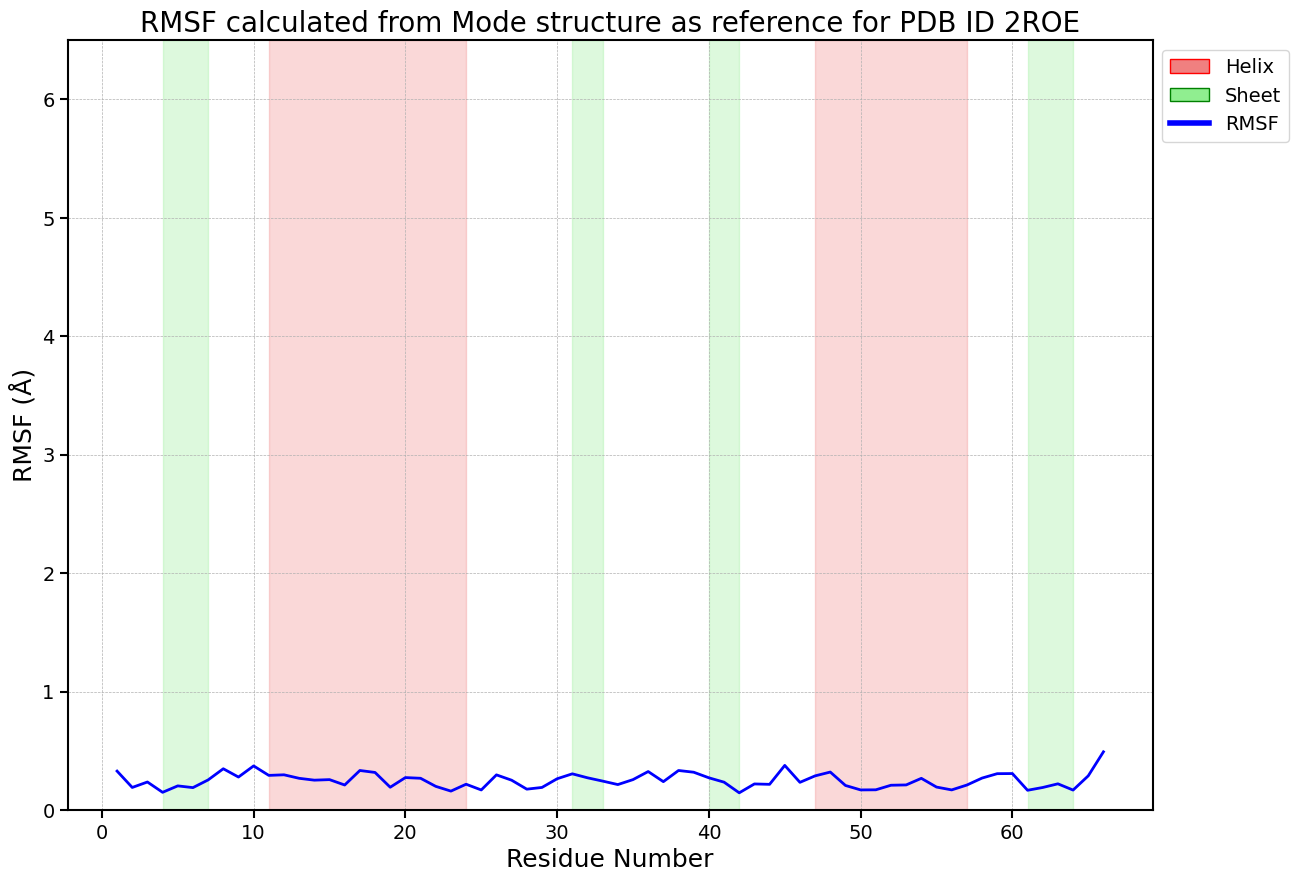

RMSF plot saved as 2ROE_rmsf_plot_mode.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:567: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


RMSF values saved to 2ROG_rmsf_mode.csv


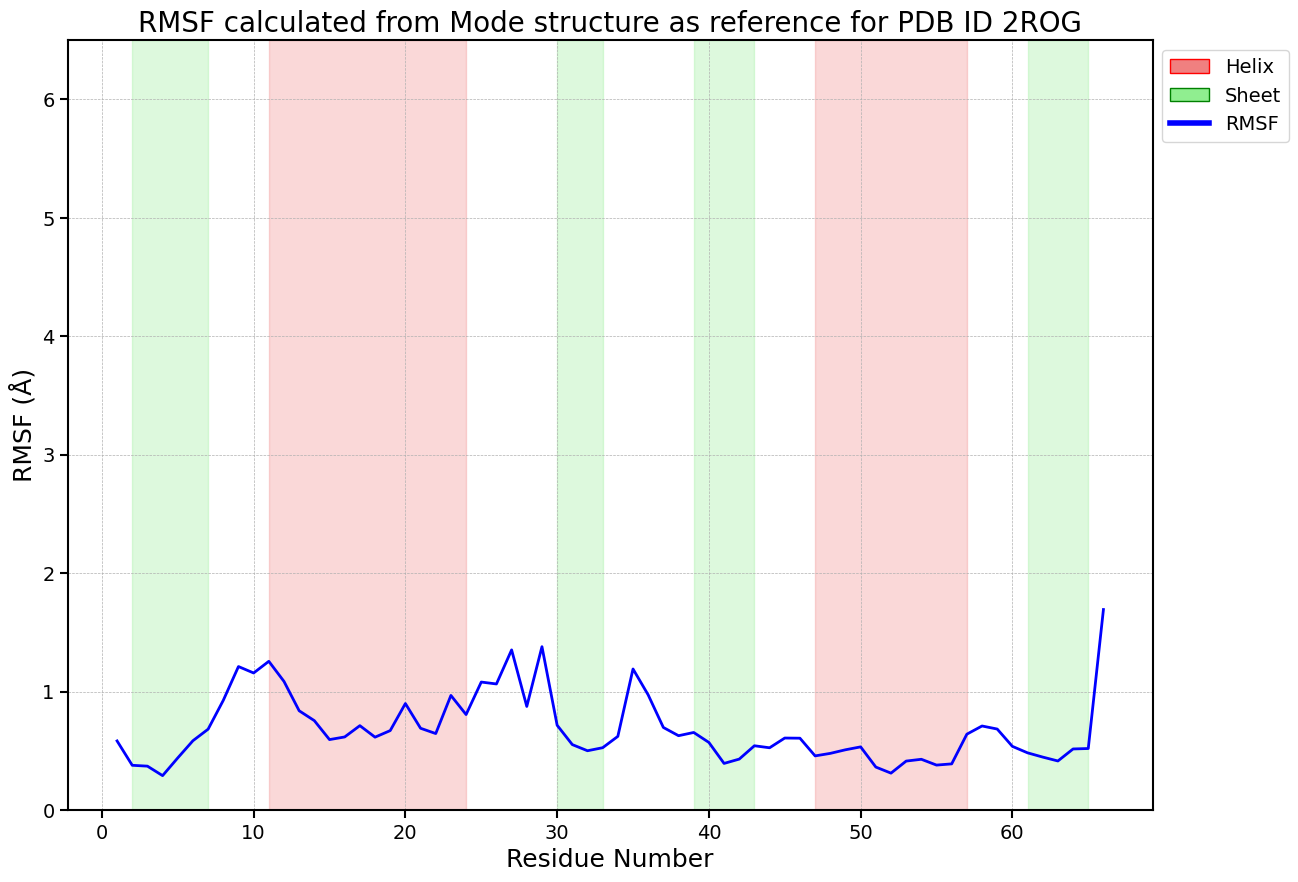

RMSF plot saved as 2ROG_rmsf_plot_mode.png


In [ ]:
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from Bio.PDB import *
from sklearn.cluster import AgglomerativeClustering
import csv

class NMR:
    def __init__(self, pdb_file):
        self.structure = self.load_structure(pdb_file)
        self.models = self.extract_models()
        self.num_models = len(self.models)
        self.ca_coords, self.residue_numbers, self.secondary_structure = self.parse_coordinates_and_secondary_structure(pdb_file)
        self.mode_structure, self.labels = self.find_mode_structure()

    def load_structure(self, pdb_file):
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("NMR", pdb_file)
        return structure

    def extract_models(self):
        models = [model for model in self.structure.get_models()]
        return models

    def parse_coordinates_and_secondary_structure(self, pdb_file):
        #Parse atomic coordinates and secondary structure from PDB file
        models = []
        residue_numbers = []
        secondary_structure = []

        current_model = []
        current_residues = []

        with open(pdb_file, 'r') as file:
            for line in file:
                record_type = line[:6].strip()

                if record_type == 'MODEL':
                    current_model = []
                    current_residues = []

                elif record_type == 'ENDMDL':
                    models.append(current_model)
                    residue_numbers.append(current_residues)

                elif record_type == 'ATOM' and line[12:16].strip() == 'CA':
                    x = float(line[30:38])
                    y = float(line[38:46])
                    z = float(line[46:54])
                    res_num = int(line[22:26].strip())
                    current_model.append([x, y, z])
                    current_residues.append(res_num)

                elif record_type in ('HELIX', 'SHEET'):
                    sec_struct_type = line[:6].strip()
                    start_res = line[21:26].strip()
                    end_res = line[33:37].strip()

                    try:
                        start_res = int(start_res)
                        end_res = int(end_res)
                    except ValueError:
                        start_res = ''.join(filter(str.isdigit, start_res))
                        end_res = ''.join(filter(str.isdigit, end_res))
                        if start_res and end_res:
                            start_res = int(start_res)
                            end_res = int(end_res)

                    secondary_structure.append((sec_struct_type, start_res, end_res))

        return np.array(models), residue_numbers[0], secondary_structure

    def find_mode_structure(self):
        # Calculate pairwise RMSD
        rmsd_matrix = np.zeros((self.num_models, self.num_models))
        for i in range(self.num_models):
            for j in range(i + 1, self.num_models):
                rmsd = self.calculate_rmsd(self.ca_coords[i], self.ca_coords[j])
                rmsd_matrix[i, j] = rmsd
                rmsd_matrix[j, i] = rmsd

        # Perform hierarchical clustering
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=5.0, linkage='average').fit(rmsd_matrix)

        # Identify the largest cluster
        labels = clustering.labels_
        unique_labels, counts = np.unique(labels, return_counts=True)
        largest_cluster_label = unique_labels[np.argmax(counts)]

        # Find all models in the largest cluster
        cluster_indices = np.where(labels == largest_cluster_label)[0]

        # Calculate the model with the minimum average RMSD to all other models in the cluster
        min_avg_rmsd = float('inf')
        mode_structure_index = cluster_indices[0]
        for i in cluster_indices:
            avg_rmsd = np.mean([self.calculate_rmsd(self.ca_coords[i], self.ca_coords[j]) for j in cluster_indices if i != j])
            if avg_rmsd < min_avg_rmsd:
                min_avg_rmsd = avg_rmsd
                mode_structure_index = i

        mode_structure = self.models[mode_structure_index]

        return mode_structure, labels

    def calculate_rmsd(self, coords1, coords2):
        # Calculate RMSD between two sets of coordinates
        diff = coords1 - coords2
        rmsd = np.sqrt(np.mean(np.sum(diff ** 2, axis=1)))
        return rmsd

    def calculate_rmsf(self):
        #Calculate RMSF for each residue
        mode_ca_coords = np.array([atom.get_coord() for atom in self.mode_structure.get_atoms() if atom.get_name() == 'CA'])
        rmsf_values = np.sqrt(np.mean((self.ca_coords - mode_ca_coords) ** 2, axis=(0, 2)))
        residue_numbers = np.array(self.residue_numbers)
        return rmsf_values, residue_numbers, self.secondary_structure

    def save_rmsf_to_csv(self, rmsf_values, residue_numbers, pdb_id):
        #Save RMSF values to CSV file
        filename = f"{pdb_id}_rmsf_mode.csv"
        with open(filename, 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(['Residue Number', 'RMSF'])
            for res_num, rmsf in zip(residue_numbers, rmsf_values):
                csvwriter.writerow([res_num, rmsf])
        print(f"RMSF values saved to {filename}")

    def write_pdb(self, structure, filename):
        # Write structure to PDB file
        io = PDBIO()
        io.set_structure(structure)
        io.save(filename)

    def plot_rmsf(self, rmsf_values, residue_numbers, secondary_structure, pdb_id):
        #Plot RMSF values and secondary structure information
        plt.figure(figsize=(14, 10))
        plt.plot(residue_numbers, rmsf_values, linestyle='-', color='blue', label='RMSF', linewidth=2, markersize=8)
        legend_elements = []
        helix_shown = False
        sheet_shown = False

        for sec_type, start, end in secondary_structure:
            if sec_type == 'HELIX':
                color = 'lightcoral'
                if not helix_shown:
                    legend_elements.append(Patch(facecolor=color, edgecolor='red', label='Helix'))
                    helix_shown = True
            elif sec_type == 'SHEET':
                color = 'lightgreen'
                if not sheet_shown:
                    legend_elements.append(Patch(facecolor=color, edgecolor='green', label='Sheet'))
                    sheet_shown = True
            else:
                color = 'grey'

            plt.axvspan(start, end, color=color, alpha=0.3)

        legend_elements.append(plt.Line2D([0], [0], color='blue', lw=4, label='RMSF'))
        plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)

        plt.title(f"RMSF calculated from Mode structure as reference for PDB ID {pdb_id}", fontsize=20)
        plt.xlabel("Residue Number", fontsize=18)
        plt.ylabel("RMSF (Å)", fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylim(0, 6.5)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.gca().spines['top'].set_linewidth(1.5)
        plt.gca().spines['right'].set_linewidth(1.5)
        plt.gca().spines['bottom'].set_linewidth(1.5)
        plt.gca().spines['left'].set_linewidth(1.5)
        plt.gca().tick_params(width=1.5, length=6)
        plt.savefig(f"{pdb_id}_rmsf_plot_mode.png", dpi=300, bbox_inches='tight')
        plt.show()
        print(f"RMSF plot saved as {pdb_id}_rmsf_plot_mode.png")

def download_pdb(pdb_id, filename):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    response.raise_for_status()
    with open(filename, 'wb') as file:
        file.write(response.content)

if __name__ == '__main__':
    pdb_ids = ["2ROE", "2ROG"]  # List of PDB IDs for different conditions

    for pdb_id in pdb_ids:
        pdb_file = f"{pdb_id}.pdb"

        # Download PDB file
        download_pdb(pdb_id, pdb_file)

        # Initialize NMR class
        nmr = NMR(pdb_file)

        # Calculate RMSF
        rmsf_values, residue_numbers, secondary_structure = nmr.calculate_rmsf()

        # Save RMSF to CSV
        nmr.save_rmsf_to_csv(rmsf_values, residue_numbers, pdb_id)

        # Plot RMSF
        nmr.plot_rmsf(rmsf_values, residue_numbers, secondary_structure, pdb_id)